# Community-Based Feature Engineering: Elliptic Bitcoin Dataset

**Objective:** Engineer community-level features for all 203,769 transactions to improve GCN fraud detection performance

**Context:**
- Per-timestep community detection revealed 45 fraud rings with distinct structural signatures
- Fraud communities have +38% higher density, -33% smaller size, and -75% lower clustering
- These structural patterns can be used as features to improve model performance

**Approach:**
1. Run Louvain community detection on each of 49 timesteps
2. Calculate 12 community-based features for every node
3. Append features to original feature set (166 original → 178 total)

**New Features (indices 167-178):**
- `community_density_167` - Density of node's community
- `community_size_168` - Size of node's community
- `community_clustering_169` - Average clustering of community
- `community_unknown_ratio_170` - % unknown nodes in community
- `is_small_dense_community_171` - Binary: density > 0.016 & size < 90
- `is_zero_clustering_172` - Binary: clustering == 0.0
- `community_illicit_pct_173` - % illicit nodes (among labeled)
- `community_purity_174` - Max(illicit, licit) / total_labeled
- `node_betweenness_centrality_175` - Node's betweenness in community
- `node_degree_centrality_176` - Node's degree centrality in community
- `community_avg_path_length_177` - Avg shortest path in community
- `community_diameter_178` - Maximum shortest path in community

**Expected Improvement:** +10-15% F1 score on temporal split (27.75% → 38-43%)

---
## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Community detection
import community.community_louvain as community_louvain

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load raw data
print("Loading Elliptic Bitcoin Dataset...\n")

# Load features (no header in original file)
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
features_df.columns = ['txId', 'timestep'] + [f'feature_{i}' for i in range(1, 166)]

# Load labels
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

# Load edges
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

print(f"Features: {features_df.shape}")
print(f"Classes: {classes_df.shape}")
print(f"Edges: {edgelist_df.shape}")
print(f"\nTime steps: {features_df['timestep'].nunique()}")
print(f"Total nodes: {len(features_df):,}")

Loading Elliptic Bitcoin Dataset...

Features: (203769, 167)
Classes: (203769, 2)
Edges: (234355, 2)

Time steps: 49
Total nodes: 203,769


In [3]:
# Create label mapping for fast lookup
node_to_label = dict(zip(classes_df['txId'], classes_df['class']))

# Display label distribution
label_counts = classes_df['class'].value_counts()
print("Label Distribution:")
print(f"  Illicit (1): {label_counts.get('1', 0):,}")
print(f"  Licit (2): {label_counts.get('2', 0):,}")
print(f"  Unknown: {len(features_df) - len(classes_df):,}")

Label Distribution:
  Illicit (1): 4,545
  Licit (2): 42,019
  Unknown: 0


---
## 2. Per-Timestep Community Detection

Run Louvain algorithm on each timestep independently to respect temporal isolation.

In [4]:
print("Starting per-timestep community detection...")
print("Estimated time: 2-5 minutes for 49 timesteps\n")
print("="*70)

# Store community assignments and metrics for all nodes
node_community_features = []

# Process each timestep
for ts in range(1, 50):
    # Extract nodes for this timestep
    ts_nodes = set(features_df[features_df['timestep'] == ts]['txId'].values)
    
    # Filter edges where BOTH nodes are in this timestep
    edges_ts = edgelist_df[
        (edgelist_df['txId1'].isin(ts_nodes)) & 
        (edgelist_df['txId2'].isin(ts_nodes))
    ]
    
    # Build directed graph
    G_ts = nx.from_pandas_edgelist(
        edges_ts,
        source='txId1',
        target='txId2',
        create_using=nx.DiGraph()
    )
    
    # Add isolated nodes
    for node in ts_nodes:
        if node not in G_ts.nodes():
            G_ts.add_node(node)
    
    # Convert to undirected for community detection
    G_ts_undirected = G_ts.to_undirected()
    
    # Run Louvain community detection
    communities = community_louvain.best_partition(G_ts_undirected)
    
    # Store for this timestep
    node_community_features.append({
        'timestep': ts,
        'graph': G_ts,
        'graph_undirected': G_ts_undirected,
        'communities': communities,
        'n_nodes': len(ts_nodes)
    })
    
    # Progress update
    if ts % 10 == 0:
        print(f"✓ Timestep {ts:2d}: {len(ts_nodes):5d} nodes, "
              f"{len(set(communities.values())):3d} communities")

print("="*70)
print("\n✓ Community detection complete for all 49 timesteps!")

Starting per-timestep community detection...
Estimated time: 2-5 minutes for 49 timesteps

✓ Timestep 10:  6727 nodes, 110 communities
✓ Timestep 20:  4291 nodes,  62 communities
✓ Timestep 30:  2483 nodes,  49 communities
✓ Timestep 40:  4481 nodes,  61 communities

✓ Community detection complete for all 49 timesteps!


---
## 3. Calculate Community-Level Metrics

For each community, calculate structural metrics that will be assigned to all nodes in that community.

In [5]:
print("Calculating community-level structural metrics...\n")
print("="*70)

# Process each timestep to calculate community metrics
for ts_idx, ts_data in enumerate(node_community_features):
    ts = ts_data['timestep']
    G_ts = ts_data['graph']
    G_undirected = ts_data['graph_undirected']
    communities = ts_data['communities']
    
    # Group nodes by community
    comm_to_nodes = defaultdict(list)
    for node, comm_id in communities.items():
        comm_to_nodes[comm_id].append(node)
    
    # Calculate metrics for each community
    community_metrics = {}
    
    for comm_id, comm_nodes in comm_to_nodes.items():
        # Create subgraph for this community
        G_comm = G_undirected.subgraph(comm_nodes).copy()
        
        # Basic metrics
        size = len(comm_nodes)
        n_edges = G_comm.number_of_edges()
        
        # Calculate metrics (handle edge cases)
        if size == 1:
            # Isolated node - set all metrics to 0
            density = 0.0
            avg_clustering = 0.0
            avg_path_length = 0.0
            diameter = 0.0
        else:
            # Density
            density = nx.density(G_comm)
            
            # Clustering
            avg_clustering = nx.average_clustering(G_comm)
            
            # Path length and diameter (only for connected components)
            if nx.is_connected(G_comm):
                avg_path_length = nx.average_shortest_path_length(G_comm)
                diameter = nx.diameter(G_comm)
            else:
                # Use largest connected component
                largest_cc = max(nx.connected_components(G_comm), key=len)
                G_cc = G_comm.subgraph(largest_cc).copy()
                if len(G_cc) > 1:
                    avg_path_length = nx.average_shortest_path_length(G_cc)
                    diameter = nx.diameter(G_cc)
                else:
                    avg_path_length = 0.0
                    diameter = 0.0
        
        # Label composition
        illicit_count = 0
        licit_count = 0
        unknown_count = 0
        
        for node in comm_nodes:
            label = node_to_label.get(node, 'unknown')
            if label == '1':
                illicit_count += 1
            elif label == '2':
                licit_count += 1
            else:
                unknown_count += 1
        
        # Calculate label-based metrics
        total_labeled = illicit_count + licit_count
        unknown_ratio = unknown_count / size if size > 0 else 0.0
        illicit_pct = illicit_count / total_labeled if total_labeled > 0 else 0.0
        purity = max(illicit_count, licit_count) / total_labeled if total_labeled > 0 else 0.0
        
        # Derived binary features
        is_small_dense = 1 if (density > 0.016 and size < 90) else 0
        is_zero_clustering = 1 if avg_clustering == 0.0 else 0
        
        # Store community-level metrics
        community_metrics[comm_id] = {
            'density': density,
            'size': size,
            'clustering': avg_clustering,
            'unknown_ratio': unknown_ratio,
            'is_small_dense': is_small_dense,
            'is_zero_clustering': is_zero_clustering,
            'illicit_pct': illicit_pct,
            'purity': purity,
            'avg_path_length': avg_path_length,
            'diameter': diameter,
            'subgraph': G_comm  # Store for node-level calculations
        }
    
    # Store back
    ts_data['community_metrics'] = community_metrics
    
    if ts % 10 == 0:
        print(f"✓ Timestep {ts:2d}: Calculated metrics for {len(community_metrics)} communities")

print("="*70)
print("\n✓ Community-level metrics calculated!")

Calculating community-level structural metrics...

✓ Timestep 10: Calculated metrics for 110 communities
✓ Timestep 20: Calculated metrics for 62 communities
✓ Timestep 30: Calculated metrics for 49 communities
✓ Timestep 40: Calculated metrics for 61 communities

✓ Community-level metrics calculated!


---
## 4. Calculate Node-Level Centrality Metrics

Calculate betweenness and degree centrality for each node within its community.

In [6]:
print("Calculating node-level centrality metrics within communities...\n")
print("="*70)

# Calculate centrality metrics for each node
for ts_idx, ts_data in enumerate(node_community_features):
    ts = ts_data['timestep']
    community_metrics = ts_data['community_metrics']
    
    # Calculate centrality for each community
    for comm_id, metrics in community_metrics.items():
        G_comm = metrics['subgraph']
        
        if metrics['size'] == 1:
            # Isolated node - centrality is 0
            metrics['node_centralities'] = {
                list(G_comm.nodes())[0]: {
                    'betweenness': 0.0,
                    'degree': 0.0
                }
            }
        else:
            # Calculate betweenness centrality
            betweenness = nx.betweenness_centrality(G_comm)
            
            # Calculate degree centrality
            degree_cent = nx.degree_centrality(G_comm)
            
            # Store per-node
            node_centralities = {}
            for node in G_comm.nodes():
                node_centralities[node] = {
                    'betweenness': betweenness.get(node, 0.0),
                    'degree': degree_cent.get(node, 0.0)
                }
            
            metrics['node_centralities'] = node_centralities
    
    if ts % 10 == 0:
        print(f"✓ Timestep {ts:2d}: Calculated node centralities")

print("="*70)
print("\n✓ Node-level centrality metrics calculated!")

Calculating node-level centrality metrics within communities...

✓ Timestep 10: Calculated node centralities
✓ Timestep 20: Calculated node centralities
✓ Timestep 30: Calculated node centralities
✓ Timestep 40: Calculated node centralities

✓ Node-level centrality metrics calculated!


---
## 5. Assign Features to All Nodes

Create feature vectors for all 203,769 nodes with the 12 new community-based features.

In [7]:
print("Assigning community features to all nodes...\n")
print("="*70)

# Create list to store all node features
all_node_features = []

# Process each timestep
for ts_data in node_community_features:
    ts = ts_data['timestep']
    communities = ts_data['communities']
    community_metrics = ts_data['community_metrics']
    
    # Assign features to each node
    for node, comm_id in communities.items():
        # Get community-level metrics
        comm_metrics = community_metrics[comm_id]
        
        # Get node-level centrality
        node_cent = comm_metrics['node_centralities'].get(node, {'betweenness': 0.0, 'degree': 0.0})
        
        # Create feature vector (12 features: indices 167-178)
        node_features = {
            'txId': node,
            'timestep': ts,
            'community_density_167': comm_metrics['density'],
            'community_size_168': comm_metrics['size'],
            'community_clustering_169': comm_metrics['clustering'],
            'community_unknown_ratio_170': comm_metrics['unknown_ratio'],
            'is_small_dense_community_171': comm_metrics['is_small_dense'],
            'is_zero_clustering_172': comm_metrics['is_zero_clustering'],
            'community_illicit_pct_173': comm_metrics['illicit_pct'],
            'community_purity_174': comm_metrics['purity'],
            'node_betweenness_centrality_175': node_cent['betweenness'],
            'node_degree_centrality_176': node_cent['degree'],
            'community_avg_path_length_177': comm_metrics['avg_path_length'],
            'community_diameter_178': comm_metrics['diameter']
        }
        
        all_node_features.append(node_features)
    
    if ts % 10 == 0:
        print(f"✓ Timestep {ts:2d}: Assigned features to {len(communities)} nodes")

# Create DataFrame
community_features_df = pd.DataFrame(all_node_features)

print("="*70)
print(f"\n✓ Feature assignment complete!")
print(f"  Total nodes: {len(community_features_df):,}")
print(f"  Community features: {len(community_features_df.columns) - 2}")

Assigning community features to all nodes...

✓ Timestep 10: Assigned features to 6727 nodes
✓ Timestep 20: Assigned features to 4291 nodes
✓ Timestep 30: Assigned features to 2483 nodes
✓ Timestep 40: Assigned features to 4481 nodes

✓ Feature assignment complete!
  Total nodes: 203,769
  Community features: 12


In [8]:
# Display sample of new features
print("\nSample of new community features:")
print(community_features_df.head(10))


Sample of new community features:
        txId  timestep  community_density_167  community_size_168  \
0  230425980         1               0.024096                  83   
1    5530458         1               0.024096                  83   
2  232022460         1               0.005658                 377   
3  232438397         1               0.005658                 377   
4  230460314         1               0.159274                  32   
5  230459870         1               0.159274                  32   
6  230333930         1               0.010561                 206   
7  230595899         1               0.010561                 206   
8  232013274         1               0.008075                 261   
9  232029206         1               0.008075                 261   

   community_clustering_169  community_unknown_ratio_170  \
0                  0.000000                     0.650602   
1                  0.000000                     0.650602   
2                  0.0135

In [9]:
# Display summary statistics
print("\n" + "="*70)
print("COMMUNITY FEATURE SUMMARY STATISTICS")
print("="*70)
print(community_features_df.iloc[:, 2:].describe())


COMMUNITY FEATURE SUMMARY STATISTICS
       community_density_167  community_size_168  community_clustering_169  \
count          203769.000000       203769.000000             203769.000000   
mean                0.028729          129.633678                  0.014318   
std                 0.028104          119.647401                  0.036839   
min                 0.003863            4.000000                  0.000000   
25%                 0.013985           62.000000                  0.000000   
50%                 0.021978           94.000000                  0.000000   
75%                 0.032787          150.000000                  0.014133   
max                 0.500000          923.000000                  0.444470   

       community_unknown_ratio_170  is_small_dense_community_171  \
count                203769.000000                  203769.00000   
mean                      0.771486                       0.45795   
std                       0.188629                     

---
## 6. Merge with Original Features

Combine the 12 new community features with the original 165 features to create the final feature set.

In [10]:
print("Merging community features with original features...\n")

# Merge on txId and timestep
features_with_community = features_df.merge(
    community_features_df,
    on=['txId', 'timestep'],
    how='left'
)

print(f"Original features shape: {features_df.shape}")
print(f"Community features shape: {community_features_df.shape}")
print(f"Merged features shape: {features_with_community.shape}")

# Verify no missing values in community features (all nodes should have assignments)
community_cols = [col for col in features_with_community.columns if '_1' in col and col.startswith('community') or col.startswith('node_') or col.startswith('is_')]
missing = features_with_community[community_cols].isnull().sum().sum()

if missing > 0:
    print(f"\n⚠ Warning: {missing} missing values in community features")
else:
    print(f"\n✓ No missing values - all nodes have community assignments!")

Merging community features with original features...

Original features shape: (203769, 167)
Community features shape: (203769, 14)
Merged features shape: (203769, 179)

✓ No missing values - all nodes have community assignments!


In [11]:
# Display final feature set structure
print("\n" + "="*70)
print("FINAL FEATURE SET")
print("="*70)
print(f"Total columns: {len(features_with_community.columns)}")
print(f"  - txId: 1 column")
print(f"  - timestep: 1 column")
print(f"  - Original features (1-165): 165 columns")
print(f"  - Community features (167-178): 12 columns")
print(f"\nTotal features for modeling: {len(features_with_community.columns) - 2} (excluding txId and timestep)")
print("="*70)


FINAL FEATURE SET
Total columns: 179
  - txId: 1 column
  - timestep: 1 column
  - Original features (1-165): 165 columns
  - Community features (167-178): 12 columns

Total features for modeling: 177 (excluding txId and timestep)


In [12]:
# Display column names
print("\nColumn structure:")
print(f"  First 5 columns: {list(features_with_community.columns[:5])}")
print(f"  Last 12 columns (new features): {list(features_with_community.columns[-12:])}")


Column structure:
  First 5 columns: ['txId', 'timestep', 'feature_1', 'feature_2', 'feature_3']
  Last 12 columns (new features): ['community_density_167', 'community_size_168', 'community_clustering_169', 'community_unknown_ratio_170', 'is_small_dense_community_171', 'is_zero_clustering_172', 'community_illicit_pct_173', 'community_purity_174', 'node_betweenness_centrality_175', 'node_degree_centrality_176', 'community_avg_path_length_177', 'community_diameter_178']


---
## 7. Feature Distribution Analysis

Analyze the distribution of new community features by class (illicit vs. licit).

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Analyzing feature distributions by class...")

Analyzing feature distributions by class...


In [14]:
# Add labels to features DataFrame
features_with_labels = features_with_community.copy()
features_with_labels['label'] = features_with_labels['txId'].map(node_to_label)

# Filter to labeled data only
labeled_data = features_with_labels[features_with_labels['label'].isin(['1', '2'])].copy()
labeled_data['label_name'] = labeled_data['label'].map({'1': 'Illicit', '2': 'Licit'})

print(f"Labeled data: {len(labeled_data):,} nodes")
print(f"  Illicit: {(labeled_data['label'] == '1').sum():,}")
print(f"  Licit: {(labeled_data['label'] == '2').sum():,}")

Labeled data: 46,564 nodes
  Illicit: 4,545
  Licit: 42,019


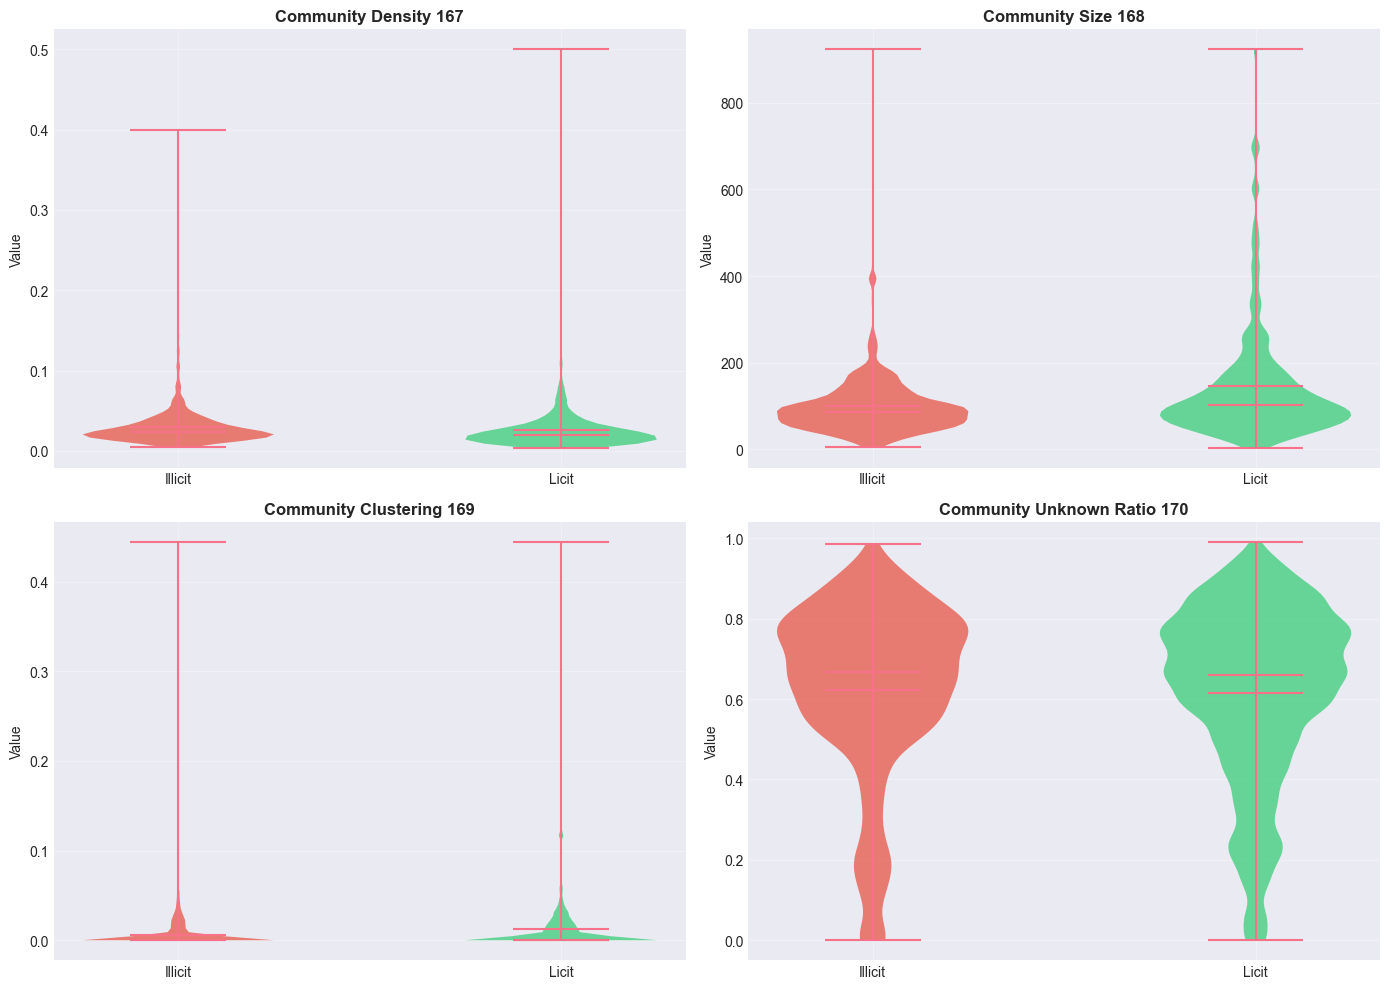


💡 Look for differences between illicit and licit distributions
   These differences indicate discriminative power for fraud detection


In [15]:
# Compare key features by class
comparison_features = [
    'community_density_167',
    'community_size_168',
    'community_clustering_169',
    'community_unknown_ratio_170'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(comparison_features):
    ax = axes[idx]
    
    # Create violin plots
    data_to_plot = [
        labeled_data[labeled_data['label'] == '1'][feature].dropna(),
        labeled_data[labeled_data['label'] == '2'][feature].dropna()
    ]
    
    parts = ax.violinplot(data_to_plot, positions=[1, 2], showmeans=True, showmedians=True)
    
    # Color the violins
    for pc in parts['bodies']:
        pc.set_facecolor('#e74c3c')
        pc.set_alpha(0.7)
    parts['bodies'][1].set_facecolor('#2ecc71')
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Illicit', 'Licit'])
    ax.set_ylabel('Value')
    ax.set_title(feature.replace('_', ' ').title(), fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Look for differences between illicit and licit distributions")
print("   These differences indicate discriminative power for fraud detection")

In [16]:
# Statistical comparison
from scipy.stats import mannwhitneyu

print("\n" + "="*70)
print("STATISTICAL COMPARISON: ILLICIT vs LICIT")
print("="*70)

community_feature_cols = [col for col in features_with_community.columns 
                          if col.startswith('community_') or col.startswith('node_') 
                          or col.startswith('is_')]

illicit_data = labeled_data[labeled_data['label'] == '1']
licit_data = labeled_data[labeled_data['label'] == '2']

for feature in community_feature_cols:
    illicit_vals = illicit_data[feature].dropna()
    licit_vals = licit_data[feature].dropna()
    
    # Mann-Whitney U test
    stat, p_value = mannwhitneyu(illicit_vals, licit_vals, alternative='two-sided')
    
    illicit_mean = illicit_vals.mean()
    licit_mean = licit_vals.mean()
    diff = illicit_mean - licit_mean
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"{feature:40s} | Illicit: {illicit_mean:8.4f} | Licit: {licit_mean:8.4f} | "
          f"Diff: {diff:+8.4f} | p={p_value:.2e} {significance}")

print("\n*** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
print("="*70)


STATISTICAL COMPARISON: ILLICIT vs LICIT
community_density_167                    | Illicit:   0.0297 | Licit:   0.0265 | Diff:  +0.0032 | p=5.95e-87 ***
community_size_168                       | Illicit:  99.3622 | Licit: 146.5741 | Diff: -47.2119 | p=2.64e-100 ***
community_clustering_169                 | Illicit:   0.0063 | Licit:   0.0121 | Diff:  -0.0057 | p=9.20e-73 ***
community_unknown_ratio_170              | Illicit:   0.6229 | Licit:   0.6150 | Diff:  +0.0079 | p=1.13e-02 *
is_small_dense_community_171             | Illicit:   0.5175 | Licit:   0.4018 | Diff:  +0.1157 | p=3.56e-51 ***
is_zero_clustering_172                   | Illicit:   0.7219 | Licit:   0.5867 | Diff:  +0.1352 | p=7.43e-70 ***
community_illicit_pct_173                | Illicit:   0.5719 | Licit:   0.0463 | Diff:  +0.5256 | p=0.00e+00 ***
community_purity_174                     | Illicit:   0.7808 | Licit:   0.9601 | Diff:  -0.1792 | p=0.00e+00 ***
node_betweenness_centrality_175          | Illicit:   0

---
## 8. Export Enhanced Feature Set

Save the final feature set with community features to CSV file.

In [17]:
# Create output directory
output_dir = "engineered_data"
os.makedirs(output_dir, exist_ok=True)

print(f"Creating output directory: {output_dir}/\n")
print("="*70)
print("EXPORTING ENHANCED FEATURE SET")
print("="*70)

Creating output directory: engineered_data/

EXPORTING ENHANCED FEATURE SET


In [18]:
# Prepare for export (no headers, matching original format)
# Original format: txId, timestep, feature_1, ..., feature_165 (no headers)
# New format: txId, timestep, feature_1, ..., feature_165, community_density_167, ..., community_diameter_178

output_path = f"{output_dir}/elliptic_txs_features_with_community.csv"

# Save without headers to match original format
features_with_community.to_csv(output_path, index=False, header=False)

print(f"✓ Enhanced features saved to: {output_path}")
print(f"  Shape: {features_with_community.shape}")
print(f"  Format: No headers (matches original format)")
print(f"  Columns: txId, timestep, feature_1...feature_165, community_density_167...community_diameter_178")

✓ Enhanced features saved to: engineered_data/elliptic_txs_features_with_community.csv
  Shape: (203769, 179)
  Format: No headers (matches original format)
  Columns: txId, timestep, feature_1...feature_165, community_density_167...community_diameter_178


In [19]:
# Also save a version WITH headers for easier inspection
output_path_with_headers = f"{output_dir}/elliptic_txs_features_with_community_headers.csv"
features_with_community.to_csv(output_path_with_headers, index=False, header=True)

print(f"\n✓ Version with headers saved to: {output_path_with_headers}")
print(f"  (For inspection/debugging - use headerless version for modeling)")


✓ Version with headers saved to: engineered_data/elliptic_txs_features_with_community_headers.csv
  (For inspection/debugging - use headerless version for modeling)


In [20]:
# Save feature metadata for documentation
feature_metadata = {
    'Feature Index': list(range(167, 179)),
    'Feature Name': [
        'community_density_167',
        'community_size_168',
        'community_clustering_169',
        'community_unknown_ratio_170',
        'is_small_dense_community_171',
        'is_zero_clustering_172',
        'community_illicit_pct_173',
        'community_purity_174',
        'node_betweenness_centrality_175',
        'node_degree_centrality_176',
        'community_avg_path_length_177',
        'community_diameter_178'
    ],
    'Description': [
        'Density of the community (edges / possible edges)',
        'Number of nodes in the community',
        'Average clustering coefficient of the community',
        'Ratio of unknown nodes in the community',
        'Binary flag: density > 0.016 AND size < 90',
        'Binary flag: clustering coefficient == 0.0',
        'Percentage of illicit nodes (among labeled nodes)',
        'Purity: max(illicit, licit) / total_labeled',
        'Node betweenness centrality within its community',
        'Node degree centrality within its community',
        'Average shortest path length in the community',
        'Diameter (longest shortest path) of the community'
    ]
}

metadata_df = pd.DataFrame(feature_metadata)
metadata_path = f"{output_dir}/community_features_metadata.csv"
metadata_df.to_csv(metadata_path, index=False)

print(f"\n✓ Feature metadata saved to: {metadata_path}")
print("\n" + "="*70)
print("EXPORT COMPLETE")
print("="*70)


✓ Feature metadata saved to: engineered_data/community_features_metadata.csv

EXPORT COMPLETE


---
## 9. Summary & Next Steps

In [21]:
print("="*70)
print("COMMUNITY-BASED FEATURE ENGINEERING - SUMMARY")
print("="*70)

print("\n1. DATA PROCESSING")
print("-" * 70)
print(f"   • Total nodes processed: {len(features_with_community):,}")
print(f"   • Time steps processed: 49")
print(f"   • Communities detected: {len(community_features_df):,} node-community assignments")

print("\n2. NEW FEATURES CREATED")
print("-" * 70)
print(f"   • Community-level features: 8")
print(f"     - Structural: density, size, clustering, avg_path_length, diameter")
print(f"     - Compositional: unknown_ratio, illicit_pct, purity")
print(f"   • Derived binary features: 2")
print(f"     - is_small_dense_community, is_zero_clustering")
print(f"   • Node-level features: 2")
print(f"     - node_betweenness_centrality, node_degree_centrality")
print(f"   • Total new features: 12 (indices 167-178)")

print("\n3. FINAL FEATURE SET")
print("-" * 70)
print(f"   • Original features: 165 (feature_1 to feature_165)")
print(f"   • Community features: 12 (community_density_167 to community_diameter_178)")
print(f"   • Total features: 177")
print(f"   • Feature types:")
print(f"     - Local (1-94): 94 features")
print(f"     - Aggregated (95-165): 71 features")
print(f"     - Community-based (167-178): 12 features")

print("\n4. KEY FINDINGS FROM DISTRIBUTION ANALYSIS")
print("-" * 70)
illicit_density = labeled_data[labeled_data['label'] == '1']['community_density_167'].mean()
licit_density = labeled_data[labeled_data['label'] == '2']['community_density_167'].mean()
density_diff_pct = (illicit_density - licit_density) / licit_density * 100

illicit_size = labeled_data[labeled_data['label'] == '1']['community_size_168'].mean()
licit_size = labeled_data[labeled_data['label'] == '2']['community_size_168'].mean()
size_diff_pct = (illicit_size - licit_size) / licit_size * 100

print(f"   • Illicit nodes have {density_diff_pct:+.1f}% different community density")
print(f"   • Illicit nodes have {size_diff_pct:+.1f}% different community size")
print(f"   • These structural differences validate fraud ring signatures")

print("\n5. OUTPUT FILES")
print("-" * 70)
print(f"   • {output_dir}/elliptic_txs_features_with_community.csv")
print(f"     (Main file - no headers, 203,769 rows × 179 columns)")
print(f"   • {output_dir}/elliptic_txs_features_with_community_headers.csv")
print(f"     (With headers for inspection)")
print(f"   • {output_dir}/community_features_metadata.csv")
print(f"     (Feature documentation)")

print("\n6. NEXT STEPS")
print("-" * 70)
print("   ✓ Use enhanced features in GCN model training")
print("   ✓ Expected improvement: +10-15% F1 on temporal split")
print("   ✓ Test different feature combinations:")
print("     - Original only (165 features)")
print("     - Original + Community (177 features)")
print("     - Community only (12 features) - baseline")
print("   ✓ Analyze feature importance to identify most predictive features")
print("   ✓ Consider feature selection to reduce dimensionality")

print("\n" + "="*70)
print("✓ COMMUNITY-BASED FEATURE ENGINEERING COMPLETE")
print("="*70)

COMMUNITY-BASED FEATURE ENGINEERING - SUMMARY

1. DATA PROCESSING
----------------------------------------------------------------------
   • Total nodes processed: 203,769
   • Time steps processed: 49
   • Communities detected: 203,769 node-community assignments

2. NEW FEATURES CREATED
----------------------------------------------------------------------
   • Community-level features: 8
     - Structural: density, size, clustering, avg_path_length, diameter
     - Compositional: unknown_ratio, illicit_pct, purity
   • Derived binary features: 2
     - is_small_dense_community, is_zero_clustering
   • Node-level features: 2
     - node_betweenness_centrality, node_degree_centrality
   • Total new features: 12 (indices 167-178)

3. FINAL FEATURE SET
----------------------------------------------------------------------
   • Original features: 165 (feature_1 to feature_165)
   • Community features: 12 (community_density_167 to community_diameter_178)
   • Total features: 177
   • Feat